# Notebook to replicate supplemental control figures for visual behavior paper

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle


# import visual_behavior.data_access.loading as loading # Files should be saved in a clear location
# import visual_behavior.data_access.utilities as utilities
import visual_behavior.visualization.utils as utils

import seaborn as sns
import jetplot
import matplotlib.colors
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting # functions to plot clusters
from visual_behavior.dimensionality_reduction.clustering import processing # function for computing and validating clusters

import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [4]:
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
run_examples=False # skip example runs to run the notebook faster

# Cell ID shuffle control

## Supplemental figure 20

#### Load data

In [6]:
experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

In [7]:
# path to data file
base_path = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache_new'
#base_path = os.path.abspath(path)

# create folder to load and save to
folder = 'clustering'
save_dir = os.path.join(base_path, folder)


In [11]:
fig_path = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_figures_final'


#### Load original feature matrix, meta data and cluster labels

In [9]:
filename = 'clustering_feature_matrix.h5'
original_feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')
len(original_feature_matrix)

3921

In [18]:
filename = 'old_files/cluster_meta_14_clusters.h5' 
original_cluster_meta = pd.read_hdf(os.path.join(save_dir, filename), key='df')
original_cluster_meta.head()

,cluster_id,labels,ophys_experiment_id,equipment_name,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,...,layer,area_layer,date,first_novel,n_relative_to_first_novel,last_familiar,last_familiar_active,second_novel,second_novel_active,experience_exposure
cell_specimen_id,,,,,,,,,,,,,,,,,,,,,
1086489847,9,0,1003771765,CAM2P.3,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,486737,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,192.0,...,upper,VISp_upper,20200129,False,-2.0,False,True,False,False,Familiar > 3
1086489860,2,4,1003771765,CAM2P.3,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,486737,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,192.0,...,upper,VISp_upper,20200129,False,-2.0,False,True,False,False,Familiar > 3
1086489891,9,0,1003771765,CAM2P.3,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,486737,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,192.0,...,upper,VISp_upper,20200129,False,-2.0,False,True,False,False,Familiar > 3
1086489976,4,9,962471831,CAM2P.5,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467302,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,177.0,...,lower,VISp_lower,20191007,False,-1.0,True,True,False,False,Familiar 3
1086490002,4,9,962471831,CAM2P.5,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467302,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],M,177.0,...,lower,VISp_lower,20191007,False,-1.0,True,True,False,False,Familiar 3


In [20]:

filename = 'old_files/cell_metadata.pkl'
cells_table = pd.read_pickle(os.path.join(save_dir, filename))

#cells_table = pd.read_hdf(os.path.join(save_dir, filename), key='df')
#matched_cells_table = loading.get_matched_cells_table(cells_table)

In [51]:
save_dir

'//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_cache_new\\clustering'

In [23]:
filename = 'old_files/matched_cells_table.pkl'
cells_table = pd.read_pickle(os.path.join(save_dir, filename))

### Compute mean cluster coding scores for the original data

In [24]:
original_mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(original_feature_matrix, 
                                                  cluster_meta = original_cluster_meta.reset_index(), sort=True)
original_mean_dropout_scores_unstacked = processing.get_mean_dropout_scores_per_cluster(original_feature_matrix, stacked=False, 
                                                  cluster_meta = original_cluster_meta.reset_index(), sort=True)

In [25]:
# split cell specimen ids by cre lines
cre_ids = {}
cre_lines = np.sort(original_cluster_meta.cre_line.unique())
for cre_line in cre_lines:
    cre_ids[cre_line]=original_cluster_meta[original_cluster_meta.cre_line==cre_line].index.values
    

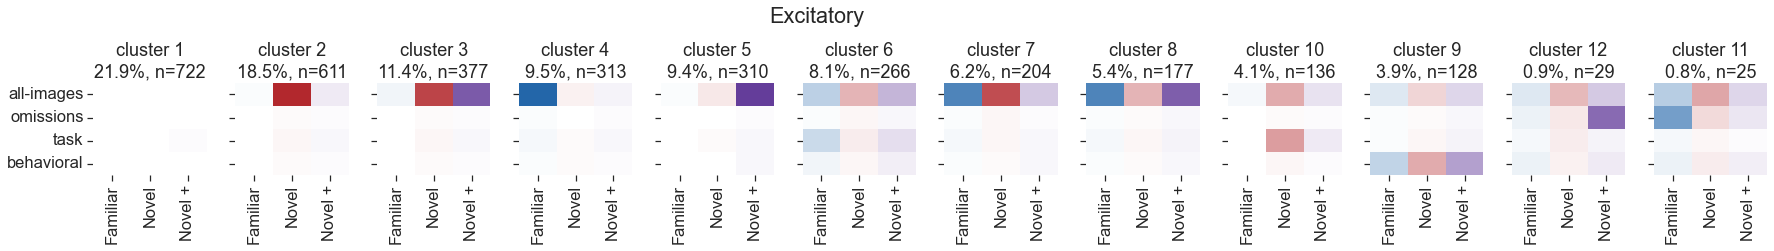

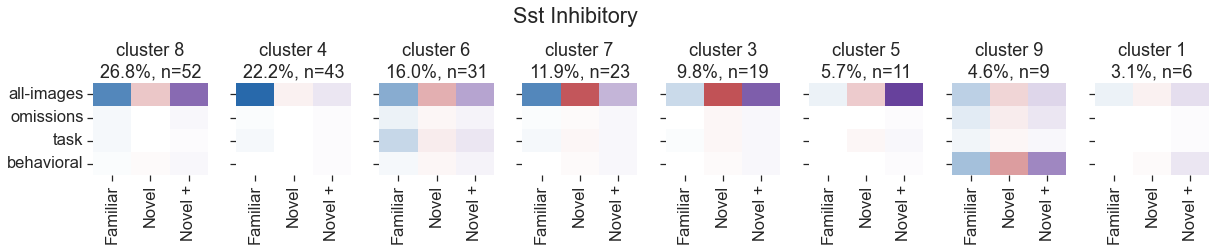

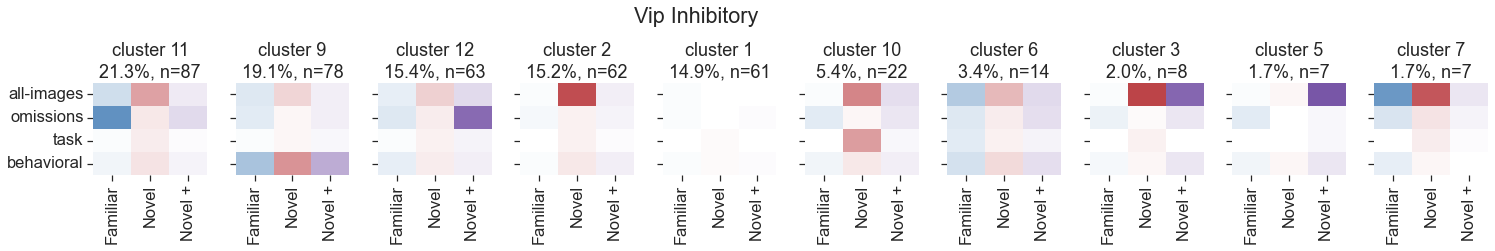

In [136]:
for cre_line in cre_lines:
    cluster_meta_cre = original_cluster_meta[original_cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(original_feature_matrix, cluster_meta_cre, cre_line, clusters, session_colors=True, save_dir=None, folder=None)

#### Load shuffled data

In [27]:
tmp_dir = r'C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache\cluster_controls'
shuffle_dir = os.path.join(tmp_dir, 'shuffled_files')
print('Change to save dir once files finish copying')
n_boots=np.arange(500)
shuffle_type = 'experience'
nb_shuffled = {}
for n_boot in n_boots:
    nb_filename ='all_cells_{}_nb{}.h5'.format(shuffle_type, n_boot)
    feature_matrix = pd.read_hdf(os.path.join(shuffle_dir,nb_filename), key = 'df')
    nb_shuffled[n_boot] = feature_matrix.rename(mapper = {'Novel 1': 'Novel', 'Novel >1': 'Novel +'}, axis=1)
shuffled_feature_matrices = nb_shuffled

Change to save dir once files finish copying


In [28]:
len(shuffled_feature_matrices)

500

In [20]:
# to create new shuffled data:
if run_examples:
    shuffled_matrix_example = processing.shuffle_dropout_score(feature_matrix, shuffle_type='experience', separate_cre_lines=False)

shuffling data across experience


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\core\fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


array([<AxesSubplot:title={'center':'Excitatory'}, xlabel='experience_level'>,
       <AxesSubplot:title={'center':'Sst Inhibitory'}, xlabel='experience_level'>,
       <AxesSubplot:title={'center':'Vip Inhibitory'}, xlabel='experience_level'>],
      dtype=object)

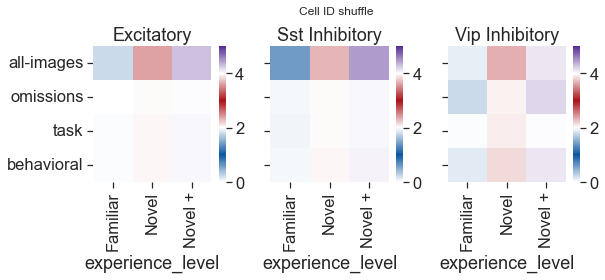

In [29]:
# plot mean dropout scores for shuffled dataset, which should look like the original
plotting.plot_mean_shuffled_feature_matrix(shuffled_feature_matrices, original_cluster_meta, 
                                           session_colors=True, experience_index=None, save_dir=None)


#### Cluster shuffled data

In [33]:
if run_examples:
    # example of clustering one shuffled dataset.
    # to apply it to multiple shuffled dataset, loop through shuffled_feature_matrices
    from sklearn.cluster import SpectralClustering
    n_clusters=12 # same as what we have in original data, this can be optimized for each clustering iteration, but would be very time consuming.
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150)) #
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)
    shuffled_cluster_meta = processing.create_and_save_cluster_meta(coclustering_df, n_clusters, feature_matrix, cells_table_matched, cluster_meta_filename=None)


#### Load cluster labels

In [34]:
%%time
## Load shuffled cluster labels
nb_labels_shuffled = {}                       
for n_boot in n_boots:
    nb_filename ='all_cells_{}_nb{}_cluster_labels.h5'.format(shuffle_type, n_boot) 
    full_filename = os.path.join(shuffle_dir, nb_filename)
    nb_labels_shuffled[n_boot] = pd.read_hdf(full_filename, key = 'clustered_df')
shuffled_labels = nb_labels_shuffled

Wall time: 8.8 s


## Compute mean dropout scores for each cluster, each shuffle type, cre_line, and nboot from shuffled dfs

Mean dropout scores are needed for each cluster in order to match original clusters with shuffled

In [36]:
n_clusters=12

In [94]:
# mean dropout scores for all 12 clusters in each iteration of shuffle for all cell types together
# these averages are what is used to compare shuffled clusters to original clusters when computing SSE

nb_mean_dropout_scores_shuffled = {}
for n, n_boot in enumerate(n_boots):
    cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
    feature_matrix = nb_shuffled[n][processing.get_features_for_clustering()] # shuffled feature matrix
    mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix, 
                                                      cluster_meta = cluster_meta, stacked=True, max_n_clusters=n_clusters)
    nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores


In [142]:
dropout_df=feature_matrix, 
cluster_meta = cluster_meta, 
labels=None, 
stacked=False, 
sort=False, 
max_n_clusters=n_clusters


cluster_ids = np.arange(1, max_n_clusters + 1)
cluster_meta = shuffled_labels[n]

# new cluster ids will start with 1, and they will be sorted by cluster size
mean_cluster = {}
for i, cluster_id in enumerate(cluster_ids):
    this_cluster_ids = cluster_meta[cluster_meta['cluster_id'] == cluster_id]['cell_specimen_id'].unique()
    if stacked is True:
        mean_dropout_df = dropout_df.loc[this_cluster_ids].mean()
        mean_cluster[cluster_id] = mean_dropout_df.values
    elif stacked is False:
        mean_dropout_df = dropout_df.loc[this_cluster_ids].mean().unstack()
        mean_cluster[cluster_id] = mean_dropout_df.loc[get_features_for_clustering()]



In [143]:
mean_cluster

{}

In [107]:
nb_mean_dropout_scores_shuffled_unstacked = {}
for n, n_boot in enumerate(n_boots):
    cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
    feature_matrix = nb_shuffled[n][processing.get_features_for_clustering()] # shuffled feature matrix
    mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix, 
                                                      cluster_meta = cluster_meta, stacked=False,max_n_clusters=n_clusters)
    nb_mean_dropout_scores_shuffled_unstacked[n] = mean_dropout_scores

In [111]:
nb_mean_dropout_scores_shuffled_unstacked[100][10]

experience_level,Familiar,Novel,Novel +
all-images,0.082015,0.833871,0.825767
omissions,0.011231,0.038958,0.025221
task,0.028385,0.062139,0.050684
behavioral,0.024704,0.025036,0.029382


In [96]:
# mean dropout scores for all 12 clusters in each iteration of shuffle separated by cre lines
# This is helpful for plotting clusters for each cre line
cre_mean_dropout_scores_shuffled = {}
for cre_line in cre_lines:
    nb_mean_dropout_scores_shuffled = {}
    for n, n_boot in enumerate(n_boots):
        cluster_meta = shuffled_labels[n] # cluster ids with cell specimen ids
        cluster_meta_cre  = cluster_meta[cluster_meta.cre_line==cre_line]
        cids = cluster_meta_cre.cell_specimen_id.values
            
        feature_matrix = nb_shuffled[n][processing.get_features_for_clustering()] # shuffled feature matrix
        feature_matrix_cre = feature_matrix.loc[cids] 
        mean_dropout_scores = processing.get_mean_dropout_scores_per_cluster(feature_matrix_cre, 
                                                      cluster_meta = cluster_meta_cre, max_n_clusters=n_clusters)
        nb_mean_dropout_scores_shuffled[n] = mean_dropout_scores
    cre_mean_dropout_scores_shuffled[cre_line] = nb_mean_dropout_scores_shuffled

### panel c and d - SSE matching heatmap 


In [41]:
# Compute Sum of Squared Error between original clusters and each iteration of shuffled clusters. 
# Low value indicates better match

SSE_matrix_filename = os.path.join(save_dir, 'SSE_matrix_shuffled_nboot.pkl')
if os.path.exists(SSE_matrix_filename):
    with open(SSE_matrix_filename, 'rb') as f:
        SSE_matrix = pickle.load(f)
else:
    SSE_matrix = {}
    for n, n_boot in enumerate(n_boots):
        shuffled_mean_dropout_scores = nb_mean_dropout_scores_shuffled[n]
        SSE_matrix[n] = processing.compute_SSE(original_mean_dropout_scores, shuffled_mean_dropout_scores)
    with open(SSE_matrix_filename, 'wb') as f:
        pickle.dump(SSE_matrix, f)
    
# find best matching clusters. If lowest SSE value is above the threshold, no match was found.
SSE_mapping = processing.get_cluster_mapping(SSE_matrix, threshold = 0.1)
    

In [52]:
filename = os.path.join(save_dir,'old_files/sorted_SSE_matrix.h5')
if os.path.exists(filename):
    SSE_matrix_sorted = pd.read_hdf(filename, key='df')
else:
    SSE_matrix_sorted = processing.sort_SSE_values(SSE_matrix, SSE_mapping)

In [43]:
# this is the same as original_mean_dropout_scores, but with exp and regressor labels and transposed
original_cluster_means = plotting.get_cluster_means(original_feature_matrix, original_cluster_meta)


In [97]:
# get mean dropout scores for matched clusters
shuffled_clusters_dict = processing.get_matched_clusters_means_dict(SSE_mapping, nb_mean_dropout_scores_shuffled_unstacked, 
                                                                    metric='mean', shuffle_type=None, cre_line=None) 
        
shuffled_cluster_means = processing.get_shuffled_cluster_means(shuffled_clusters_dict, n_clusters)

In [122]:
nb_mean_dropout_scores_shuffled_unstacked[10][3]

experience_level,Familiar,Novel,Novel +
all-images,0.041694,0.818231,0.083792
omissions,0.010299,0.039225,0.013941
task,0.024465,0.066481,0.035437
behavioral,0.010729,0.028101,0.020191


In [130]:
n_boots = SSE_mapping.keys()
cluster_ids = SSE_mapping[0].keys()
columns = nb_mean_dropout_scores_shuffled_unstacked[0][1].columns
for cluster_id in [10]:
    # get dropout scores for matched clusters across each shuffle iteration
    all_matched_cluster_meta = pd.DataFrame(columns=columns)
    all_matched_cluster_meta
    for n_boot in n_boots:
        matched_cluster_id = SSE_mapping[n_boot][cluster_id]
        if matched_cluster_id != -1:
            all_matched_cluster_meta = all_matched_cluster_meta.append(
                nb_mean_dropout_scores_shuffled_unstacked[n_boot][matched_cluster_id])

    #all_matched_cluster_meta = all_matched_cluster_meta.reset_index().rename(columns={'index': 'regressor'})
        

In [132]:
nb_mean_dropout_scores_shuffled_unstacked[n_boot][matched_cluster_id]

experience_level,Familiar,Novel,Novel +
all-images,0.151324,0.214689,0.217650
omissions,0.037481,0.052100,0.032363
task,0.039228,0.085444,0.026660
behavioral,0.026388,0.571745,0.057495


In [131]:
all_matched_cluster_meta

experience_level,Familiar,Novel,Novel +
all-images,0.147250,0.215564,0.238819
omissions,0.044907,0.054485,0.053549
task,0.024385,0.060622,0.030295
behavioral,0.052727,0.599066,0.058075
all-images,0.195342,0.220645,0.237151
...,...,...,...
behavioral,0.046620,0.597607,0.031389
all-images,0.151324,0.214689,0.217650
omissions,0.037481,0.052100,0.032363
task,0.039228,0.085444,0.026660


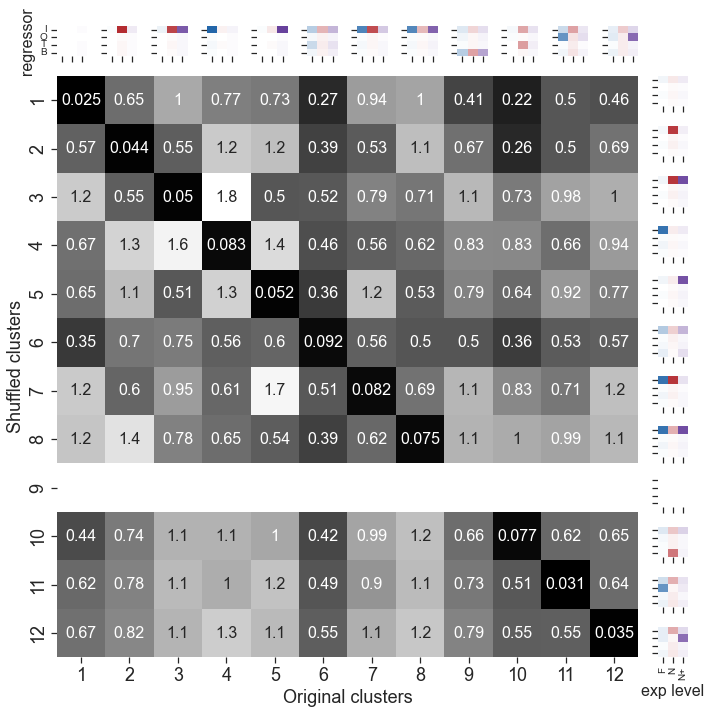

In [112]:
plotting.plot_cluster_heatmaps_with_SSE_matrix(original_cluster_means, shuffled_cluster_means, SSE_matrix_sorted,
                                               session_colors=True, experience_index=None, save_dir=None, folder=None)

## panels e and f probability of clusters in shuffled data

In [152]:
## Load shuffled cluster labels
shuffled_labels_cre={}
for cre_line in cre_lines:
    nb_labels_shuffled = {}                       
    for n_boot in n_boots:
        nb_filename ='all_cells_{}_nb{}_cluster_labels.h5'.format(shuffle_type, n_boot) 
        full_filename = os.path.join(shuffle_dir, nb_filename)
        cluster_meta = pd.read_hdf(full_filename, key = 'clustered_df')
        nb_labels_shuffled[n_boot] = cluster_meta[cluster_meta.cre_line==cre_line]
    shuffled_labels_cre[cre_line] = nb_labels_shuffled


In [167]:
shuffled_cluster_sizes_cre = {}
for cre_line in cre_lines:
     shuffled_cluster_sizes_cre[cre_line] = processing.get_cluster_size_variance(SSE_mapping, shuffled_labels_cre[cre_line], normalize=False)

In [178]:
original_cluster_sizes_cre = {}
for cre_line in cre_lines:
    cluster_meta_cre = original_cluster_meta[original_cluster_meta.cre_line == cre_line]
    original_cluster_sizes_cre[cre_line] = cluster_meta_cre.value_counts('cluster_id').reindex(range(1,n_clusters+1))
    

In [209]:
filename = os.path.join(save_dir, 'difference_in_cluster_size_shuffle_control.h5')
if os.path.exists(filename):
    cluster_size_diff = pd.read_hdf(filename, key='df')
else:
    cluster_size_diff = processing.get_cluster_size_differece_df(original_cluster_sizes_cre, 
                                                             shuffled_cluster_sizes_cre, cre_line=cre_lines)
    cluster_size_diff.to_hdf(filename, key='df')

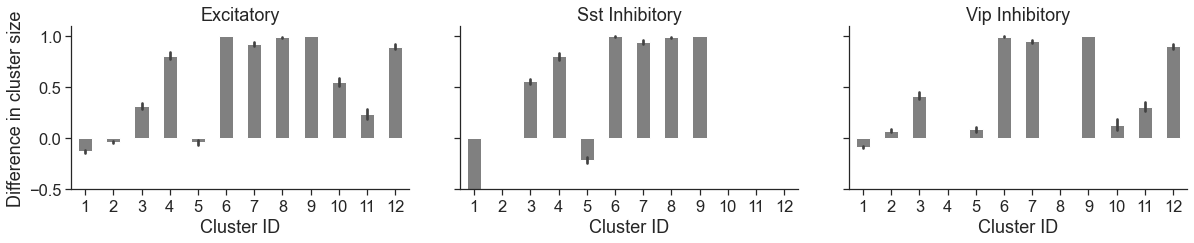

In [210]:
folder = 'figure_4/suppl_20'
plotting.plot_cluster_size_difference_for_shuffle(cluster_size_diff, save_dir=fig_path, folder=folder)

In [ ]:
plot_cluster_probability_for_shuffle(threshold, save_dir, pkl_filename)

In [144]:
probability_dict_cre = {}
for threshold in thresholds:
    for cre_line in cre_lines:
        shuffle_type_probabilities = threshold_probabilities_cre[threshold]
        probability_dict_cre[threshold]= vba_clust.get_cluster_probability_df(shuffle_type_probabilities,
                                                                              cre_line= '')
        

NameError: name 'threshold' is not defined

# Familiar control

## Supplemental figure 24

In [ ]:
cells_table = processing.get_cells_matched_in_3_familiar_active_sessions()
# add unique identifier for ophys_expt_id + csid pairs so it can be merged with results_pivoted
cells_table['identifier'] = [str(cells_table.iloc[row].ophys_experiment_id)+'_'+str(cells_table.iloc[row].cell_specimen_id) for row in range(len(cells_table))]
cells_table = cells_table.set_index('identifier')

In [ ]:
# add new experience levels for familiar active sessions to results pivoted
# and limit results pivoted to cells matched in 3 familiar sessions
results_pivoted = results_pivoted.drop(columns='experience_level')
results_pivoted = results_pivoted.merge(cells_table[[ 'experience_level']], on='identifier')
results_pivoted.experience_level.unique()

In [ ]:
print(len(results_pivoted.ophys_experiment_id.unique()))
print(len(results_pivoted.cell_specimen_id.unique()))
print(results_pivoted.project_code.unique())
print(results_pivoted.session_type.unique())

In [ ]:
# limit to features used for clustering
features = processing.get_features_for_clustering()
features = ['all-images', 'omissions', 'task', 'behavioral']
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

In [ ]:
path = r'C:\Users\iryna.yavorska\Documents\github\visual_behavior_platform_paper\data_cache'

save_dir = os.path.join(path, 'controls')
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [ ]:
# get GLM output, filter and reshape
glm_version = '24_events_all_L2_optimize_by_session'

feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

### gap statistic

In [35]:

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors
k_max = 25 #max number of clusters to test

gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    
    sc = SpectralClustering()
    gap_df = processing.compute_gap(clustering=sc, data=feature_matrix, k_max = k_max, 
                                    reference_shuffle=shuffle_type, metric=metric, separate_cre_lines=True)
    processing.save_clustering_results(gap_df, gap_filename)

loaded file


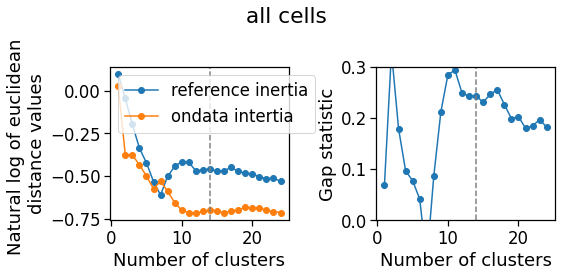

In [36]:

plotting.plot_gap_statistic(gap_df, cre_lines=['all'], n_clusters_cre=10, 
                            tag='with_cre_shuffle', save_dir=None, folder='')

### panel b and c - coclustering matrix

In [ ]:
# number of optimal clusters
n_clusters = 10

coclust_filename = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')

if os.path.exists(coclust_filename):
    coclustering_df = pd.read_hdf(coclust_filename, key='df')
    print('found and loaded cached coclustering matrix file...')
else:
    print('did not find cached coclustering matrix file, will make one...')
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(150))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_file = os.path.join(glm_path, 'coclustering_matrix_n_' + str(n_clusters) + '_clusters.h5')
    coclustering_df.to_hdf(coclust_filename, key='df', format='table')
    print('created and saved coclustering_matrix file.')

In [169]:
n_clusters = 10 # based on eigen gap

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    print('loading results')
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
# otherwise run it and save it
else: 
    # run spectral clustering and get co-clustering matrix
    from sklearn.cluster import SpectralClustering
    sc = SpectralClustering()
    X = feature_matrix.values
    m = processing.get_coClust_matrix(X=X, n_clusters=n_clusters, model=sc, nboot=np.arange(100))
    # make co-clustering matrix a dataframe with cell_specimen_ids as indices and columns
    coclustering_df = pd.DataFrame(data=m, index=feature_matrix.index, columns=feature_matrix.index)

    # save co-clustering matrix
    coclust_save_path = os.path.join(save_dir, 'coclustering_matrix_n_'+str(n_clusters)+'_clusters.h5')
    coclustering_df.to_hdf(coclust_save_path, key='df', format='table')


    # run agglomerative clustering on co-clustering matrix to identify cluster labels
    from sklearn.cluster import AgglomerativeClustering
    X = coclustering_df.values
    cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean',
                                    linkage='average')
    labels = cluster.fit_predict(X)
    cell_specimen_ids = coclustering_df.index.values
    # make dictionary with labels for each cell specimen ID in this cre line
    labels_dict = {'labels': labels, 'cell_specimen_id': cell_specimen_ids}
    # turn it into a dataframe
    labels_df = pd.DataFrame(data=labels_dict, columns=['labels', 'cell_specimen_id'])
    # get new cluster_ids based on size of clusters and add to labels_df
    cluster_size_order = labels_df['labels'].value_counts().index.values
    # translate between original labels and new IDS based on cluster size
    labels_df['cluster_id'] = [np.where(cluster_size_order == label)[0][0] for label in labels_df.labels.values]
    # concatenate with df for all cre lines
    cluster_labels = labels_df

    # limit cells_table to cells in feature_matrix and drop duplicates 
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    # cluster_meta will only have one row per cell_specimen_id 

    cluster_meta = cluster_labels[['cell_specimen_id', 'cluster_id', 'labels']].merge(cell_metadata, on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')
    cluster_meta['cluster_id'] = cluster_meta['cluster_id'].copy()+1
    # annotate & clean cluster metadata
    cluster_meta = processing.clean_cluster_meta(cluster_meta)  # drop cluster IDs with fewer than 5 cells in them
    cluster_meta['original_cluster_id'] = cluster_meta.cluster_id

    # plot coclustering matrix - need to hack it since it assumes cre lines
    coclustering_dict = {}
    coclustering_dict['all'] = coclustering_df
    cluster_meta_tmp = cluster_meta.copy()
    cluster_meta_tmp['cre_line'] = 'all'
    # plotting.plot_coclustering_matrix_sorted_by_cluster_size(coclustering_dict, cluster_meta_tmp, cre_line='all',
    #                                                 save_dir=save_dir, folder=folder, suffix='_'+str(n_clusters)+'_clusters', ax=None)
    
    
    # add within cluster correlation
    cluster_meta = processing.add_within_cluster_corr_to_cluster_meta(feature_matrix, cluster_meta, use_spearmanr=True)

    # save clustering results
    print('saving results')
    cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')
    cluster_data = cluster_meta.reset_index()[['cell_specimen_id', 'ophys_experiment_id', 'cre_line', 'cluster_id', 'labels', 'within_cluster_correlation']]
    cluster_data.to_hdf(cluster_meta_save_path, key='df', format='table')


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


1450 cells in cell_metadata for feature_matrix
dropping 1 cells for ('Slc17a7-IRES2-Cre', 10)
dropping 1 cells for ('Slc17a7-IRES2-Cre', 11)
dropping 5 cells for ('Sst-IRES-Cre', 1)
dropping 3 cells for ('Sst-IRES-Cre', 4)
dropping 5 cells for ('Sst-IRES-Cre', 5)
dropping 1 cells for ('Sst-IRES-Cre', 6)
dropping 1 cells for ('Sst-IRES-Cre', 7)
dropping 1 cells for ('Sst-IRES-Cre', 8)
dropping 5 cells for ('Sst-IRES-Cre', 9)
dropping 1 cells for ('Sst-IRES-Cre', 11)
dropping 2 cells for ('Vip-IRES-Cre', 2)
dropping 1 cells for ('Vip-IRES-Cre', 6)
dropping 2 cells for ('Vip-IRES-Cre', 8)
dropping 2 cells for ('Vip-IRES-Cre', 9)
dropping 1 cells for ('Vip-IRES-Cre', 10)
32 cells dropped total
adding within cluster correlation to cluster_meta


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


saving results


### panel d and f - cluster heatmaps

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\pandas\core\frame.py:9203: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  validate=validate,


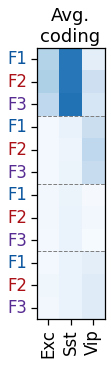

In [163]:
plotting.plot_cre_line_means_remapped(feature_matrix, cluster_meta, session_colors=False, experience_index=0)

In [ ]:
plotting.plot_cluster_means_remapped(feature_matrix, cluster_meta, session_colors=False, experience_index=0, save_dir='', folder='', ax=None)

c:\users\iryna.yavorska\documents\github\visual_behavior_analysis\visual_behavior\dimensionality_reduction\clustering\plotting.py:1649: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  if save_dir:


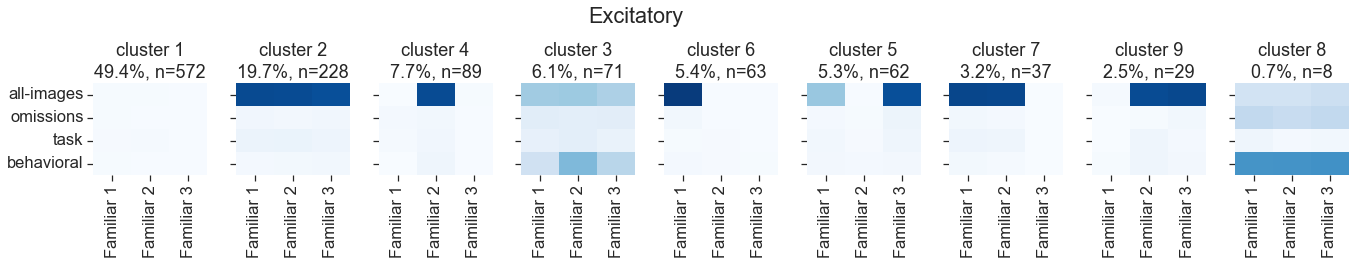

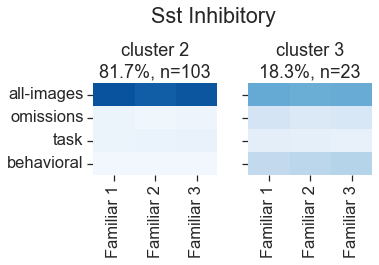

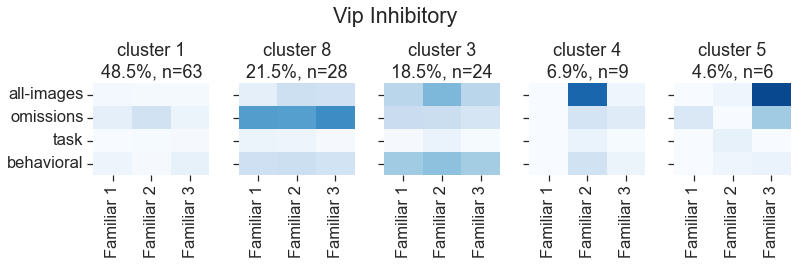

In [198]:
for cre_line in cre_lines:
    cluster_meta_cre = cluster_meta[cluster_meta.cre_line==cre_line]
    clusters = cluster_meta_cre.value_counts('cluster_id').index.values
    plotting.plot_mean_cluster_heatmaps_remapped(feature_matrix, cluster_meta_cre, cre_line, clusters, session_colors=False, experience_index=0, save_dir=None, folder=None)

### Mean response traces for clusters per cre line

In [175]:
data_type = 'events'

interpolate = True
output_sampling_rate = 30

# set inclusion criteria
# options: ['active_only', 'closest_familiar_and_novel', 'containers_with_all_levels']
inclusion_criteria = ''

In [176]:
# params for stim response df creation
event_type = 'all'

# params for mean response df creation
conditions = ['cell_specimen_id', 'is_change']


change_suffix = '_'+utils.get_conditions_string(data_type, conditions)+'_'+inclusion_criteria

multi_session_df = loading.get_multi_session_df_for_conditions(data_type, event_type, conditions, inclusion_criteria, 
                                                        interpolate=interpolate, output_sampling_rate=output_sampling_rate, 
                                                         epoch_duration_mins=None)

change_mdf = multi_session_df[multi_session_df.is_change==True]

c:\users\iryna.yavorska\documents\github\allensdk\allensdk\api\cloud_cache\cloud_cache.py:521: OutdatedManifestWarning: You are loading visual-behavior-ophys_project_manifest_v1.0.1.json. A more up to date version of the dataset -- visual-behavior-ophys_project_manifest_v1.1.0.json -- exists online. To see the changes between the two versions of the dataset, run
VisualBehaviorOphysProjectCache.compare_manifests('visual-behavior-ophys_project_manifest_v1.0.1.json', 'visual-behavior-ophys_project_manifest_v1.1.0.json')
To load another version of the dataset, run
VisualBehaviorOphysProjectCache.load_manifest('visual-behavior-ophys_project_manifest_v1.1.0.json')
  warnings.warn(msg, OutdatedManifestWarning)


loading files from \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache\multi_session_mean_response_dfs\interpolate_30Hz
mean_response_df_events_all_is_change_.pkl


  6%|████▌                                                                              | 1/18 [00:04<01:22,  4.83s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_1_images_G


 22%|██████████████████▍                                                                | 4/18 [00:09<00:29,  2.11s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_B_passive
no multi_session_df for VisualBehaviorMultiscope OPHYS_2_images_G_passive


 39%|████████████████████████████████▎                                                  | 7/18 [00:14<00:20,  1.89s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_B
no multi_session_df for VisualBehaviorMultiscope OPHYS_3_images_G
no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_A


 61%|██████████████████████████████████████████████████                                | 11/18 [00:20<00:12,  1.72s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_4_images_H
no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_A_passive


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:24<00:06,  1.62s/it]

no multi_session_df for VisualBehaviorMultiscope OPHYS_5_images_H_passive
no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_A


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:28<00:00,  1.57s/it]


no multi_session_df for VisualBehaviorMultiscope OPHYS_6_images_H


  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_A


 11%|█████████▏                                                                         | 2/18 [00:01<00:13,  1.19it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_1_images_G
no multi_session_df for VisualBehaviorTask1B OPHYS_2_images_A_passive


 28%|███████████████████████                                                            | 5/18 [00:03<00:08,  1.52it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_2_images_G_passive
no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_A


 44%|████████████████████████████████████▉                                              | 8/18 [00:05<00:06,  1.47it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_3_images_G


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:07<00:06,  1.22it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_4_images_H


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:09<00:03,  1.39it/s]

no multi_session_df for VisualBehaviorTask1B OPHYS_5_images_B_passive
no multi_session_df for VisualBehaviorTask1B OPHYS_5_images_H_passive


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:11<00:00,  1.57it/s]


no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_B
no multi_session_df for VisualBehaviorTask1B OPHYS_6_images_H


  6%|████▌                                                                              | 1/18 [00:02<00:43,  2.53s/it]

no multi_session_df for VisualBehavior OPHYS_1_images_B
no multi_session_df for VisualBehavior OPHYS_1_images_G


 22%|██████████████████▍                                                                | 4/18 [00:04<00:15,  1.09s/it]

no multi_session_df for VisualBehavior OPHYS_2_images_B_passive
no multi_session_df for VisualBehavior OPHYS_2_images_G_passive


 39%|████████████████████████████████▎                                                  | 7/18 [00:06<00:09,  1.17it/s]

no multi_session_df for VisualBehavior OPHYS_3_images_B
no multi_session_df for VisualBehavior OPHYS_3_images_G
no multi_session_df for VisualBehavior OPHYS_4_images_A


 61%|██████████████████████████████████████████████████                                | 11/18 [00:08<00:04,  1.45it/s]

no multi_session_df for VisualBehavior OPHYS_4_images_H
no multi_session_df for VisualBehavior OPHYS_5_images_A_passive


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:10<00:02,  1.52it/s]

no multi_session_df for VisualBehavior OPHYS_5_images_H_passive
no multi_session_df for VisualBehavior OPHYS_6_images_A


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:12<00:00,  1.45it/s]


no multi_session_df for VisualBehavior OPHYS_6_images_H


 17%|█████████████▊                                                                     | 3/18 [00:00<00:00, 24.66it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_1_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_2_images_A_passive
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_2_images_B_passive


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:00<00:00, 23.76it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_3_images_B
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_4_images_B


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:00<00:00, 24.47it/s]

no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_A_passive
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_5_images_B_passive
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_A
no multi_session_df for VisualBehaviorMultiscope4areasx2d OPHYS_6_images_B


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.81it/s]


saving multi session df to pkl
there are 1249 experiments in the full multi_session_df
removing 1 problematic experiments
there are 1248 experiments after filtering for inclusion criteria -  


In [177]:
import visual_behavior.visualization.ophys.platform_paper_figures as ppf

In [178]:
tmp = multi_session_df.copy()
tmp = tmp[tmp.is_change==False]
# add new experience level to to mdf by merging in cells_table
tmp = tmp.drop(columns='experience_level').merge(cells_table[['cell_specimen_id', 'ophys_experiment_id', 'experience_level']], on=['ophys_experiment_id', 'cell_specimen_id'])
# add cluster_id by merging in cluster meta
tmp = tmp.merge(cluster_meta.reset_index()[['cell_specimen_id', 'cluster_id']], on='cell_specimen_id')


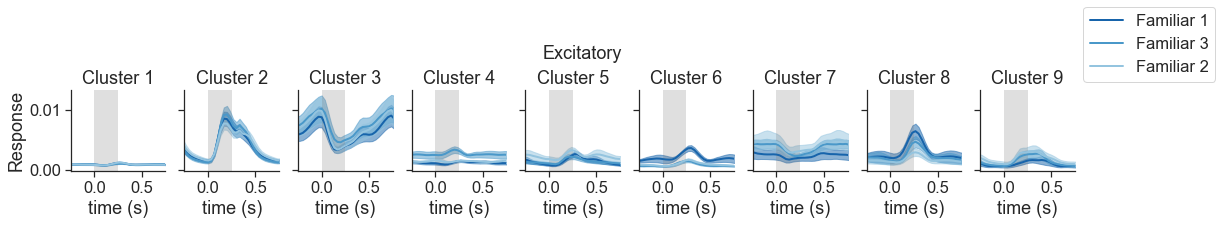

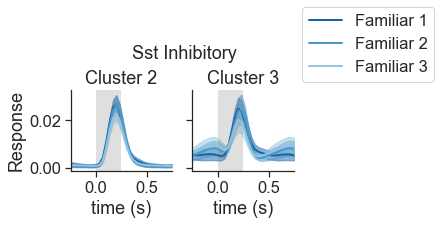

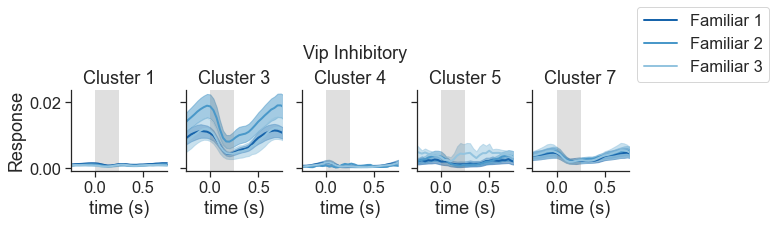

In [256]:
for cre_line in np.sort(tmp.cre_line.unique()):
    df = tmp[tmp.cre_line==cre_line].copy()

    axes_column = 'cluster_id'
    hue_column = 'experience_level'
    # xlim_seconds=[-1., 1.5]
    xlim_seconds=[-0.25, 0.75]
    cell_type = processing.get_cell_type_for_cre_line(cre_line)
    ax= plotting.plot_population_averages_for_clusters(df, event_type, axes_column, hue_column, session_colors=False, experience_index=0,legend=True,
                                            xlim_seconds=xlim_seconds, interval_sec=0.5, 
                                            sharey=True, sharex=False, 
                                            ylabel='response', xlabel='time (s)', suptitle=cell_type,
                                            save_dir=None, folder='', suffix='_sharey', ax=None);


In [ ]:
### panel e - distribution 

#### Coclustering matrix